**수업을 수강하시기 전, lec2_1.ipynb의 "수강 전 필독"을 반드시 확인해주세요**

In [ ]:
def get_returns_df(df, N=1, log=False):
    if log:
        return np.log(df / df.shift(N)).iloc[N-1:].fillna(0)
    else:
        return df.pct_change(N, fill_method=None).iloc[N-1:].fillna(0)

def get_cum_returns_df(return_df, log=False):
    if log:
        return np.exp(return_df.cumsum())
    else:
        return (1 + return_df).cumprod()    # same with (return_df.cumsum() + 1)

def get_CAGR_series(cum_rtn_df, num_day_in_year=250):
    cagr_series = cum_rtn_df.iloc[-1]**(num_day_in_year/(len(cum_rtn_df))) - 1
    return cagr_series

def get_sharpe_ratio(log_rtn_df, yearly_rfr = 0.025):
    excess_rtns = log_rtn_df.mean()*252 - yearly_rfr
    return excess_rtns / (log_rtn_df.std() * np.sqrt(252))

def get_drawdown_infos(cum_returns_df): 
    # 1. Drawdown
    cummax_df = cum_returns_df.cummax()
    dd_df = cum_returns_df / cummax_df - 1
 
    # 2. Maximum drawdown
    mdd_series = dd_df.min()

    # 3. longest_dd_period
    dd_duration_info_list = list()
    max_point_df = dd_df[dd_df == 0]
    for col in max_point_df:
        _df = max_point_df[col]
        _df.loc[dd_df[col].last_valid_index()] = 0
        _df = _df.dropna()

        periods = _df.index[1:] - _df.index[:-1]

        days = periods.days
        max_idx = days.argmax()

        longest_dd_period = days.max()
        dd_mean = int(np.mean(days))
        dd_std = int(np.std(days))

        dd_duration_info_list.append(
            [
                dd_mean,
                dd_std,
                longest_dd_period,
                "{} ~ {}".format(_df.index[:-1][max_idx].date(), _df.index[1:][max_idx].date())
            ]
        )

    dd_duration_info_df = pd.DataFrame(
        dd_duration_info_list,
        index=dd_df.columns,
        columns=['drawdown mean', 'drawdown std', 'longest days', 'longest period']
    )
    return dd_df, mdd_series, dd_duration_info_df

In [ ]:
def get_rebal_dates(price_df, period="month"):
    _price_df = price_df.reset_index()
    if period == "month":
         groupby = [_price_df['date_time'].dt.year, _price_df['date_time'].dt.month]
    elif period == "quarter":
        groupby = [_price_df['date_time'].dt.year, _price_df['date_time'].dt.quarter]
    elif period == "halfyear":
        groupby = [_price_df['date_time'].dt.year, _price_df['date_time'].dt.month // 7]
    elif period == "year":
        groupby = [_price_df['date_time'].dt.year, _price_df['date_time'].dt.year]
    rebal_dates = pd.to_datetime(_price_df.groupby(groupby)['date_time'].last().values)
    return rebal_dates

In [ ]:
from functools import reduce

def calculate_portvals(price_df, weight_df):
    cum_rtn_up_until_now = 1 
    individual_port_val_df_list = []

    prev_end_day = weight_df.index[0]
    for end_day in weight_df.index[1:]:
        sub_price_df = price_df.loc[prev_end_day:end_day]
        sub_asset_flow_df = sub_price_df / sub_price_df.iloc[0]

        weight_series = weight_df.loc[prev_end_day]
        indi_port_cum_rtn_series = (sub_asset_flow_df * weight_series) * cum_rtn_up_until_now
    
        individual_port_val_df_list.append(indi_port_cum_rtn_series)

        total_port_cum_rtn_series = indi_port_cum_rtn_series.sum(axis=1)
        cum_rtn_up_until_now = total_port_cum_rtn_series.iloc[-1]

        prev_end_day = end_day 

    individual_port_val_df = reduce(lambda x, y: pd.concat([x, y.iloc[1:]]), individual_port_val_df_list)
    return individual_port_val_df

# 자산배분의 종류

- 정적자산배분
    - constant weighting allocation
- 동적자산배분
- https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1942901 
    

In [ ]:
result_portval_dict = {} 

# 정적자산배분

## 동일 가중 buy and hold

In [ ]:
all_ticker_price_df = pd.read_csv("data/us_etf_2.csv", index_col=0, parse_dates=True)
all_ticker_price_df[['QQQ', 'IEF']]

In [ ]:
price_df = all_ticker_price_df[['QQQ', 'IEF']].dropna()
price_df.head()

In [ ]:
individual_port_val_df = price_df / price_df.iloc[0] * [0.5, 0.5]
individual_port_val_df

In [ ]:
result_portval_dict['buy_and_hold'] = individual_port_val_df.sum(axis=1)

## 동일 가중(equal weight) 리밸런싱

In [ ]:
all_ticker_price_df = pd.read_csv("data/us_etf_2.csv", index_col=0, parse_dates=True)
price_df = all_ticker_price_df[['QQQ', 'IEF']].dropna()

In [ ]:
rebal_dates = get_rebal_dates(price_df)
rebal_dates

In [ ]:
target_weight_df = pd.DataFrame(
    [[0.5, 0.5]] * len(rebal_dates),
    index=rebal_dates,
    columns=price_df.columns
)
target_weight_df

In [ ]:
individual_port_val_df = calculate_portvals(price_df, target_weight_df)
individual_port_val_df

In [ ]:
result_portval_dict['equal_weight'] = individual_port_val_df.sum(axis=1)

## 황금 나비(Golden butterfly)

- http://www.lazyportfolioetf.com/allocation/golden-butterfly/
 

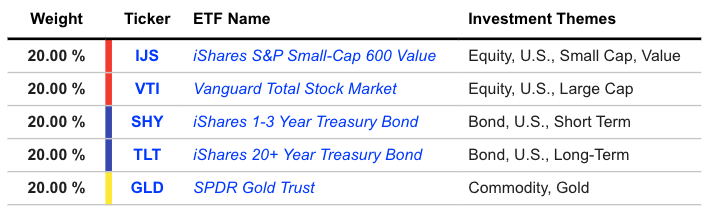

- Portfolio returns are calculated assuming:
    - a rebalancing of the components at the **beginning of each year (i.e. at every January 1st)**
    - the reinvestment of dividends

In [ ]:
all_ticker_price_df = pd.read_csv("data/us_etf_2.csv", index_col=0, parse_dates=True)
price_df = all_ticker_price_df[['IJS', 'VTI', "SHY", "TLT", "GLD"]]

In [ ]:
price_df.head(3)
price_df.tail(3)

In [ ]:
price_df = price_df.dropna(how="all")
price_df.head(3)

In [ ]:
price_df = price_df.dropna()
price_df.head(3)

In [ ]:
rebal_dates = get_rebal_dates(price_df, period="year")
rebal_dates

In [ ]:
target_weight_df = pd.DataFrame(
    [[0.2] * len(price_df.columns)] * len(rebal_dates),
    index=rebal_dates,
    columns=price_df.columns
)
target_weight_df.head(2)

In [ ]:
individual_port_val_df = calculate_portvals(price_df, target_weight_df)

In [ ]:
individual_port_val_df.sum(axis=1).plot()

In [ ]:
result_portval_dict['golden_butterfly'] = individual_port_val_df.sum(axis=1)

## 올웨더(All weather)

- http://www.lazyportfolioetf.com/allocation/ray-dalio-all-weather/

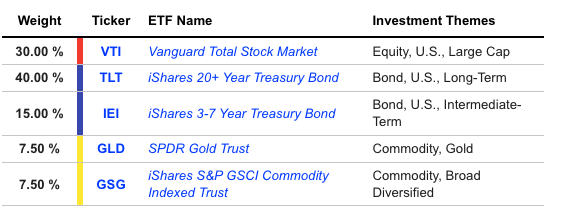

- Portfolio returns are calculated assuming:
    - a rebalancing of the components at the beginning of each year (i.e. at every January 1st)
    - the reinvestment of dividends

In [ ]:
all_ticker_price_df = pd.read_csv("data/us_etf_2.csv", index_col=0, parse_dates=True)
price_df = all_ticker_price_df[['VTI', 'TLT', "IEI", "GLD", "GSG"]]

In [ ]:
price_df = price_df.dropna()
price_df.head(3)

In [ ]:
rebal_dates = get_rebal_dates(price_df, period="year")
rebal_dates

In [ ]:
target_weight_df = pd.DataFrame(
    [[0.3, 0.4, 0.15, 0.075, 0.075]] * len(rebal_dates),
    index=rebal_dates,
    columns=price_df.columns
)
target_weight_df.head(2)

In [ ]:
individual_port_val_df = calculate_portvals(price_df, target_weight_df)

In [ ]:
individual_port_val_df.sum(axis=1).plot()

In [ ]:
result_portval_dict['all_weather'] = individual_port_val_df.sum(axis=1)

# 동적자산배분

## VAA(Vigilant Asset Allocation)

- https://www.youtube.com/watch?v=eQeu8v_-Y98
- https://lazyquant.tistory.com/2


- 공격자산 : SPY(미국주식), VEA(선진국 주식), EEM(or VWO, 개발도상국 주식), AGG(미국 총채권)
- 수비자산 : LQD(미국 회사채), SHY(미국 단기국채), IEF(미국 중기국채)


### 데이터 준비

In [ ]:
offense_assets = ["SPY", "VEA", "EEM", "AGG"]
defense_assets = ["LQD", "SHY", "IEF"]

In [ ]:
all_ticker_price_df = pd.read_csv("data/us_etf_2.csv", index_col=0, parse_dates=True)
price_df = all_ticker_price_df[
    offense_assets + defense_assets
]

In [ ]:
price_df.head()

In [ ]:
for col in price_df.columns:
    print(col, price_df[col].first_valid_index())

In [ ]:
price_df = price_df.dropna()
price_df.head(3)

In [ ]:
rebal_dates = get_rebal_dates(price_df)
rebal_dates

In [ ]:
price_df['SPY'].plot()

### momentum 구하기

In [ ]:
momentum_df = price_df.loc[rebal_dates].copy()
momentum_df.head()

In [ ]:
momentum_df.pct_change(1)

In [ ]:
momentum_result_df = (12 * momentum_df.pct_change(1)) + (4 * momentum_df.pct_change(3)) \
                                                      + (2 * momentum_df.pct_change(6)) \
                                                      + (1 * momentum_df.pct_change(12))

In [ ]:
momentum_result_df

In [ ]:
momentum_result_df = momentum_result_df.dropna()
momentum_result_df.head()

### is_defense series 구하기

In [ ]:
is_defense_series = (momentum_result_df[offense_assets] < 0).any(axis=1)
is_defense_series

In [ ]:
momentum_result_df[offense_assets].hist()

### offense weight 구하기

In [ ]:
offense_momentum_df = momentum_result_df[offense_assets]
offense_momentum_df.head()

In [ ]:
offense_weight_df = offense_momentum_df.where(
    offense_momentum_df.eq(
        offense_momentum_df.max(axis=1), 
        axis=0
    ),
#     0,
)
offense_weight_df

In [ ]:
offense_weight_df = (~offense_weight_df.isna()).astype(int)
offense_weight_df

### defense weight 구하기

In [ ]:
defense_momentum_df = momentum_result_df[defense_assets]
defense_momentum_df

In [ ]:
defense_weight_df = defense_momentum_df.where(
    defense_momentum_df.eq(
        defense_momentum_df.max(axis=1), 
        axis=0
    ),
#     0,
)

In [ ]:
defense_weight_df = (~defense_weight_df.isna()).astype(int)
defense_weight_df

### 최종 weight 구하기

In [ ]:
offense_weight_df.shape
defense_weight_df.shape

In [ ]:
is_defense_series.shape

In [ ]:
is_defense_series

In [ ]:
target_weight_df = pd.concat(
    [
        defense_weight_df.loc[is_defense_series],
        offense_weight_df.loc[~is_defense_series],
    ]
)

In [ ]:
defense_weight_df.loc[is_defense_series].head()

In [ ]:
offense_weight_df.loc[~is_defense_series].tail()

In [ ]:
target_weight_df

In [ ]:
target_weight_df = target_weight_df.fillna(0).astype(int)
target_weight_df

In [ ]:
target_weight_df = target_weight_df.sort_index()
target_weight_df.head()

### 결과

In [ ]:
individual_port_val_df = calculate_portvals(price_df, target_weight_df)
individual_port_val_df.head()

In [ ]:
result_portval_dict['vaa'] = individual_port_val_df.sum(axis=1)

In [ ]:
result_portval_dict['vaa'].plot()

In [ ]:
portval_df = result_portval_dict['vaa'].to_frame("portval")

In [ ]:
get_sharpe_ratio(get_returns_df(portval_df, log=True)).to_frame("Sharpe Ratio")

In [ ]:
get_CAGR_series(portval_df).to_frame("CAGR")

In [ ]:
dd_df, mdd_series, longest_dd_period_df = get_drawdown_infos(portval_df)
dd_df.plot(figsize=(12, 5))

### upgrade

- AGG --> threshold를 0이 아닌 -0.1로 설정 등
- offense 자산이 다 양수면,
    - equal weight
    - momentum weight
    - top 2
- offense 자산의 평균 모멘텀이 특정 threshold를 넘으면

## DAA(Defensive Asset Allocation)

- https://www.youtube.com/watch?v=2cNkblOxnFQ&t=767s
- https://lazyquant.tistory.com/entry/DAA-전략-놀라운-아이디어-카나리아야-알려줘
- 공격자산 : SPY(S&P500), IWM(러셀 2000), QQQ(나스닥), VGK(유럽 주식), EWJ(일본 주식), VWO(개발도상국 주식), VNQ(미국 리츠), GSG(원자재), GLD(금), HYG(하이일드 채권), LQD(회사채)
- 수비자산 : SHV(미국 초단기국채), IEF(미국 중기국채), UST(미국 중기채 레버리지)
- 카나리아 자산군 : VWO(개발도상국 주식), BND(미국 총채권)


### 데이터 준비

In [ ]:
offense_assets = ["SPY", "IWM", "QQQ", "VGK", "EWJ", "VWO", "VNQ", "GSG", "GLD", "HYG", "LQD",]
defense_assets = ["SHV", "IEF", "TLT"]  # UST대신 TLT로 대체
canary_assets = ["VWO", "BND"]   # VWO는 offense_asset에도 존재

In [ ]:
all_ticker_price_df = pd.read_csv("data/us_etf_2.csv", index_col=0, parse_dates=True)
price_df = all_ticker_price_df[
    list(set(offense_assets + defense_assets + canary_assets))
]

In [ ]:
for col in price_df.columns:
    print(col, price_df[col].first_valid_index())

In [ ]:
price_df = price_df.dropna()
price_df.head(3)

In [ ]:
rebal_dates = get_rebal_dates(price_df)
rebal_dates

### momentum 구하기

In [ ]:
momentum_df = price_df.loc[rebal_dates].copy()

In [ ]:
momentum_result_df = (12 * momentum_df.pct_change(1)) + (4 * momentum_df.pct_change(3)) \
                                                      + (2 * momentum_df.pct_change(6)) \
                                                      + (1 * momentum_df.pct_change(12))

In [ ]:
momentum_result_df = momentum_result_df.dropna()
momentum_result_df.head()

### canary signal 구하기

In [ ]:
canary_signal_series = (momentum_result_df[canary_assets] > 0).sum(axis=1)
canary_signal_series

In [ ]:
momentum_result_df['canary_signal'] = canary_signal_series

### weight 구하기

In [ ]:
def set_weight(series):
    canary_score = series.loc["canary_signal"]
    if canary_score == 0:
        target_assets = series.loc[defense_assets].sort_values().iloc[-1:].index
        return pd.Series([1], index=target_assets)
    elif canary_score == 1:
        target_assets1 = series.loc[offense_assets].sort_values().iloc[-2:].index
        target_assets2 = series.loc[defense_assets].sort_values().iloc[-1:].index
        return pd.Series(
            [0.25, 0.25, 0.5], 
            index=target_assets1.tolist() + target_assets2.tolist()
        )
    else:
        target_assets = series.loc[offense_assets].sort_values().iloc[-2:].index
        return pd.Series([0.5, 0.5], index=target_assets)

In [ ]:
# def set_weight(series):
#     return pd.Series([1] * len(series.index), index=series.index)

In [ ]:
target_weight_df = momentum_result_df.apply(set_weight, axis=1).fillna(0)

In [ ]:
def set_weight(series):
    print(series)

momentum_result_df.apply(set_weight, axis=1)

In [ ]:
def my_func(x):
    return x * 2

pd.Series([1,2,3,4]).apply(my_func)

### 결과

In [ ]:
individual_port_val_df = calculate_portvals(price_df, target_weight_df)

In [ ]:
result_portval_dict['daa'] = individual_port_val_df.sum(axis=1)

In [ ]:
result_portval_dict['daa'].plot()

In [ ]:
portval_df = result_portval_dict['daa'].to_frame("portval")

In [ ]:
get_sharpe_ratio(get_returns_df(portval_df, log=True)).to_frame("Sharpe Ratio")

In [ ]:
get_CAGR_series(portval_df).to_frame("CAGR")

In [ ]:
dd_df, mdd_series, longest_dd_period_df = get_drawdown_infos(portval_df)
dd_df.plot(figsize=(12, 5))

- 비교: https://lazyquant.tistory.com/80

## Inverse volatility

### 데이터 준비

In [ ]:
assets = ["SPY", "QQQ", "IEF"]

In [ ]:
all_ticker_price_df = pd.read_csv("data/us_etf_2.csv", index_col=0, parse_dates=True)
price_df = all_ticker_price_df[assets]

In [ ]:
price_df = price_df.dropna()
price_df.head(3)

In [ ]:
rebal_dates = get_rebal_dates(price_df)
rebal_dates

### volatility(std) 구하기

In [ ]:
std_series_list = []
for i in range(6, len(rebal_dates)):
    std_series = price_df.loc[
        rebal_dates[i-6]:rebal_dates[i]
    ].pct_change().std()
    std_series.name = rebal_dates[i]
    std_series_list.append(std_series)

In [ ]:
std_df = pd.concat(std_series_list, axis=1).T
std_df

### weight 구하기

In [ ]:
weight_df = 1 / std_df
weight_df

In [ ]:
target_weight_df = weight_df.divide(weight_df.sum(axis=1), axis=0)
target_weight_df

### 결과

In [ ]:
individual_port_val_df = calculate_portvals(price_df, target_weight_df)

In [ ]:
result_portval_dict['inv_vol'] = individual_port_val_df.sum(axis=1)

In [ ]:
result_portval_dict['inv_vol'].plot()

In [ ]:
portval_df = result_portval_dict['inv_vol'].to_frame("portval")

In [ ]:
get_sharpe_ratio(get_returns_df(portval_df, log=True)).to_frame("Sharpe Ratio")

In [ ]:
get_CAGR_series(portval_df).to_frame("CAGR")

In [ ]:
dd_df, mdd_series, longest_dd_period_df = get_drawdown_infos(portval_df)
dd_df.plot(figsize=(12, 5))

In [ ]:
mdd_series

# 결과비교

In [ ]:
compare_df = pd.DataFrame(result_portval_dict).dropna()
compare_df.head(2)

In [ ]:
price_df['SPY'].loc["2008-01-01":"2008-12-31"].plot()

In [ ]:
compare_df = compare_df / compare_df.iloc[0]
compare_df.head()

In [ ]:
compare_df.plot(figsize=(12, 5))

In [ ]:
get_sharpe_ratio(get_returns_df(compare_df, log=True)).sort_values(ascending=False).to_frame("Sharpe Ratio")

In [ ]:
get_CAGR_series(compare_df).sort_values(ascending=False).to_frame("CAGR")

In [ ]:
dd_df, mdd_series, longest_dd_period_df = get_drawdown_infos(compare_df)
dd_df.plot(figsize=(15, 5))

In [ ]:
mdd_series.sort_values().to_frame("MDD")

In [ ]:
longest_dd_period_df

In [ ]:
import seaborn as sns

In [ ]:
compare_df.pct_change().corr()

In [ ]:
sns.heatmap(compare_df.pct_change().corr(), cmap="coolwarm");

- rolling corr